## Save the necessary files

In [1]:
import pandas as pd
import numpy as np
import time
import gc
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, r2_score
# from s3fs.core import S3FileSystem

def global_map_plot(df, variable, vmin, vmax, cmap, title):
    # get new coordinate
    df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)

    plt.figure(figsize=(18, 12))
    map = Basemap()
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawmeridians(range(0, 360, 30),labels=[True,False,False,True],fontsize=20)
    map.drawparallels(range(-90, 100, 30), labels=[True,False,False,True],fontsize=20)
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    plt.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=6, cmap=cmap, vmin=vmin, vmax=vmax)
    clb = plt.colorbar(orientation="vertical",fraction = 0.023, pad=0.01)
    clb.ax.tick_params(labelsize=20)
    #plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1)
    plt.savefig("./"+title+"_rmse.pdf")
    plt.show()

In [2]:
# s3 = S3FileSystem()
validation_path = "/glade/scratch/zhonghua/CESM_validation/"
save_dir = "/glade/scratch/zhonghua/model-validation/"

def workflow(start_year, validation_path, save_dir):
    rmse_by_lat_lon_ls = []
    rmse_by_lat_lon_overall_ls = []
    rmse_overall_ls = []
    pcc_by_lat_lon_ls = []
    pcc_by_lat_lon_overall_ls = []
    pcc_overall_ls = []
    
    for i in range(2,34):
        member = (str(i).zfill(3))
        print("member:",member)
        t_0 = time.time()
        df=pd.read_csv(validation_path+start_year+"/"+member+"_ens.csv")
        print("It took", time.time()-t_0, "to load csv")
        
        t_1 = time.time()
        rmse_by_lat_lon = df.groupby(["lat","lon"])\
                           .apply(lambda df: np.sqrt(mean_squared_error(df["TREFMXAV_U"],
                                                                        df[member])))
        rmse_by_lat_lon_ls.append(rmse_by_lat_lon)
        
        pcc_by_lat_lon = df.groupby(["lat","lon"])\
                           .apply(lambda df: r2_score(df["TREFMXAV_U"],
                                                      df[member]))
        pcc_by_lat_lon_ls.append(pcc_by_lat_lon)
        
        
        # calculate the rmse groupped by lat/lon first, then calcuate the mean of overall gridcell
        rmse_by_lat_lon_overall = rmse_by_lat_lon.mean()
        rmse_by_lat_lon_overall_ls.append(rmse_by_lat_lon_overall)
        #print("Mean of rmse groupped by lat/lon is:", rmse_by_lat_lon_mean)
        
        # calcuate the mean of all gridcell directly (regardless of lat/lon)
        rmse_overall = np.sqrt(mean_squared_error(df["TREFMXAV_U"],df[member]))
        rmse_overall_ls.append(rmse_overall)
        #print("Overall rmse without groupby is:", rmse_overall)
        
        
        # calculate the pcc groupped by lat/lon first, then calcuate the mean of overall gridcell
        pcc_by_lat_lon_overall = pcc_by_lat_lon.mean()
        pcc_by_lat_lon_overall_ls.append(pcc_by_lat_lon_overall)
        #print("Mean of pcc groupped by lat/lon is:", pcc_by_lat_lon_mean)

        # calcuate the mean of all gridcell directly (regardless of lat/lon)
        pcc_overall = r2_score(df["TREFMXAV_U"],df[member])
        pcc_overall_ls.append(pcc_overall)
        #print("Overall pcc without groupby is:", pcc_overall)
        
        del df, rmse_by_lat_lon, rmse_by_lat_lon_overall, rmse_overall
        del pcc_by_lat_lon, pcc_by_lat_lon_overall, pcc_overall
        gc.collect()
        print("It took", time.time()-t_1, "to finish",member)
        print("\n")
    
    print("rmse by lat/lon")
    rmse_by_lat_lon=pd.concat(rmse_by_lat_lon_ls,axis=1)
    print("shape of rmse by lat/lon",rmse_by_lat_lon.shape)
    rmse_by_lat_lon.to_csv(save_dir+start_year+"/rmse_by_lat_lon.csv")
    del rmse_by_lat_lon_ls
    gc.collect()
    print("\n")
    
    print("mean of rmse by lat/lon")
    rmse_by_lat_lon_mean = rmse_by_lat_lon.mean(axis=1)
    display(rmse_by_lat_lon_mean.describe())
    rmse_by_lat_lon_mean.to_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
    del rmse_by_lat_lon
    gc.collect()
    print("\n")
    
    print("mean of mean of overall gridcell")
    rmse_by_lat_lon_overall=np.asarray(rmse_by_lat_lon_overall_ls)
    print("mean:",rmse_by_lat_lon_overall.mean())
    np.savetxt("./"+start_year+"/rmse_by_lat_lon_overall.txt",rmse_by_lat_lon_overall)
    del rmse_by_lat_lon_overall, rmse_by_lat_lon_overall_ls
    gc.collect()
    print("\n")
    
    print("mean of overall gridcell")
    rmse_overall=np.asarray(rmse_overall_ls)
    print("mean:",rmse_overall.mean())
    np.savetxt("./"+start_year+"/rmse_overall.txt",rmse_overall)
    del rmse_overall, rmse_overall_ls
    gc.collect()
    print("\n")
    
    print("pcc by lat/lon")
    pcc_by_lat_lon=pd.concat(pcc_by_lat_lon_ls,axis=1)
    print("shape of pcc by lat/lon",pcc_by_lat_lon.shape)
    pcc_by_lat_lon.to_csv(save_dir+start_year+"/pcc_by_lat_lon.csv")
    del pcc_by_lat_lon_ls
    gc.collect()
    print("\n")
    
    print("mean of pcc by lat/lon")
    pcc_by_lat_lon_mean = pcc_by_lat_lon.mean(axis=1)
    display(pcc_by_lat_lon_mean.describe())
    pcc_by_lat_lon_mean.to_csv(save_dir+start_year+"/pcc_by_lat_lon_mean.csv")
    del pcc_by_lat_lon
    gc.collect()
    print("\n")
    
    print("mean of mean of overall gridcell")
    pcc_by_lat_lon_overall=np.asarray(pcc_by_lat_lon_overall_ls)
    print("mean:",pcc_by_lat_lon_overall.mean())
    np.savetxt("./"+start_year+"/pcc_by_lat_lon_overall.txt",pcc_by_lat_lon_overall)
    del pcc_by_lat_lon_overall, pcc_by_lat_lon_overall_ls
    gc.collect()
    print("\n")
    
    print("mean of overall gridcell")
    pcc_overall=np.asarray(pcc_overall_ls)
    print("mean:",pcc_overall.mean())
    np.savetxt("./"+start_year+"/pcc_overall.txt",pcc_overall)
    del pcc_overall, pcc_overall_ls
    gc.collect()
    print("\n")
    
    return rmse_by_lat_lon_mean

## Save the necessary files

### 2006

In [3]:
start_year = "2006"
df_2006 = workflow(start_year, validation_path, save_dir)

member: 002
It took 8.210683107376099 to load csv
It took 8.181073665618896 to finish 002


member: 003
It took 8.218332767486572 to load csv
It took 8.180853366851807 to finish 003


member: 004
It took 8.204834461212158 to load csv
It took 8.201202630996704 to finish 004


member: 005
It took 8.218431234359741 to load csv
It took 8.205772161483765 to finish 005


member: 006
It took 8.232487916946411 to load csv
It took 8.192769765853882 to finish 006


member: 007
It took 8.207217931747437 to load csv
It took 8.16451382637024 to finish 007


member: 008
It took 8.16818118095398 to load csv
It took 8.065569639205933 to finish 008


member: 009
It took 8.26944088935852 to load csv
It took 8.213197708129883 to finish 009


member: 010
It took 8.126157522201538 to load csv
It took 8.186994075775146 to finish 010


member: 011
It took 8.157790899276733 to load csv
It took 8.141157150268555 to finish 011


member: 012
It took 8.119588613510132 to load csv
It took 8.144725322723389 to fini

count    4439.000000
mean        0.725124
std         0.280864
min         0.130140
25%         0.512838
50%         0.721005
75%         0.892215
max         1.707216
dtype: float64



mean of mean of overall gridcell
mean: 0.7251235995553764


mean of overall gridcell
mean: 0.778055623044725


pcc by lat/lon
shape of pcc by lat/lon (4439, 32)


mean of pcc by lat/lon


count    4439.000000
mean        0.980528
std         0.016347
min         0.852708
25%         0.973923
50%         0.985280
75%         0.992596
max         0.997797
dtype: float64



mean of mean of overall gridcell
mean: 0.98052786539975


mean of overall gridcell
mean: 0.9948990962704916




### 2061

In [4]:
start_year = "2061"
df_2061 = workflow(start_year, validation_path, save_dir)

member: 002
It took 8.336939334869385 to load csv
It took 8.544108867645264 to finish 002


member: 003
It took 8.361040115356445 to load csv
It took 8.509707689285278 to finish 003


member: 004
It took 8.325494050979614 to load csv
It took 8.511330842971802 to finish 004


member: 005
It took 8.218770742416382 to load csv
It took 8.347013235092163 to finish 005


member: 006
It took 8.259877443313599 to load csv
It took 8.36601209640503 to finish 006


member: 007
It took 8.232667446136475 to load csv
It took 8.355234384536743 to finish 007


member: 008
It took 8.306408405303955 to load csv
It took 8.383667469024658 to finish 008


member: 009
It took 8.295242309570312 to load csv
It took 8.342774152755737 to finish 009


member: 010
It took 8.243463516235352 to load csv
It took 8.327984094619751 to finish 010


member: 011
It took 8.207940101623535 to load csv
It took 8.32233715057373 to finish 011


member: 012
It took 8.209645509719849 to load csv
It took 8.316720962524414 to fin

count    4439.000000
mean        0.742657
std         0.268423
min         0.114983
25%         0.549691
50%         0.750358
75%         0.901229
max         1.719766
dtype: float64



mean of mean of overall gridcell
mean: 0.7426565549638304


mean of overall gridcell
mean: 0.7901329460756314


pcc by lat/lon
shape of pcc by lat/lon (4439, 32)


mean of pcc by lat/lon


count    4439.000000
mean        0.980316
std         0.016741
min         0.835572
25%         0.973313
50%         0.985115
75%         0.992706
max         0.997669
dtype: float64



mean of mean of overall gridcell
mean: 0.9803163636282215


mean of overall gridcell
mean: 0.9945625155352049




## rmse

### 2006

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.725124
std,25.646228,111.895429,0.280864
min,-54.188499,0.000000,0.130140
25%,8.952900,36.250000,0.512838
50%,29.685900,100.000000,0.721005
75%,42.879601,260.000000,0.892215
max,70.209396,358.750000,1.707216


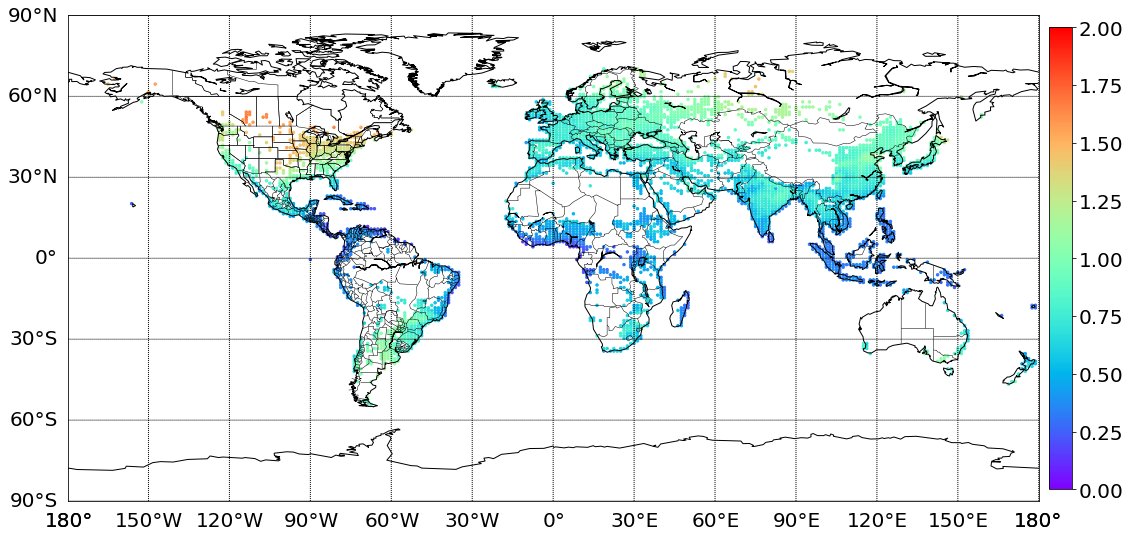

In [5]:
start_year="2006"
df_2006 = pd.read_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
# df_2006 = pd.read_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv",names=["lat", "lon", "0"])
display(df_2006.describe())
global_map_plot(df_2006, "0", 0, 2, "rainbow","2006")

### 2061

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.742657
std,25.646228,111.895429,0.268423
min,-54.188499,0.000000,0.114983
25%,8.952900,36.250000,0.549691
50%,29.685900,100.000000,0.750358
75%,42.879601,260.000000,0.901229
max,70.209396,358.750000,1.719766


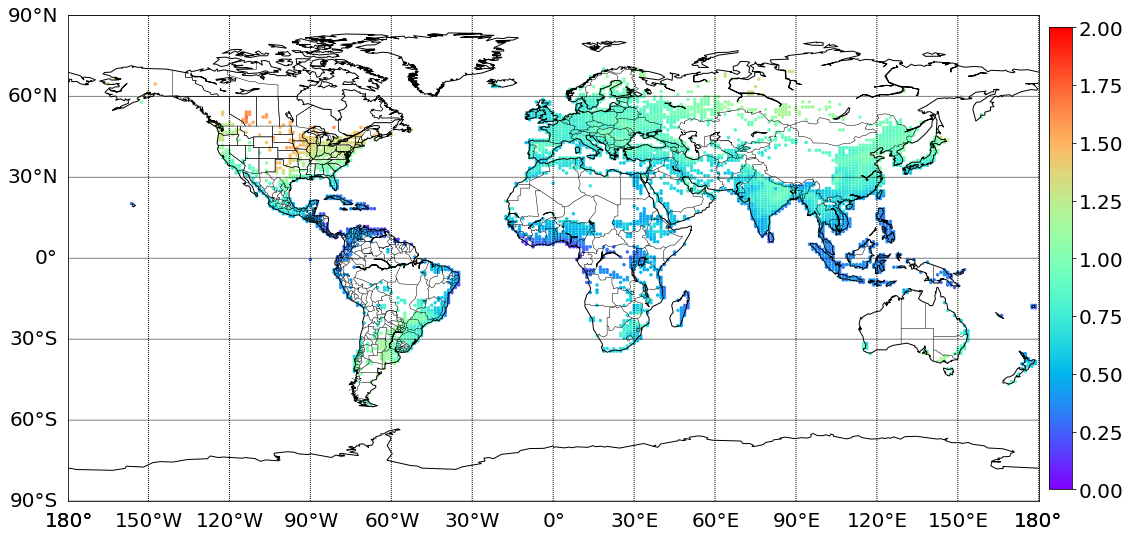

In [6]:
start_year="2061"
df_2061 = pd.read_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
# df_2061 = pd.read_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv",names=["lat", "lon", "0"])
display(df_2061.describe())
global_map_plot(df_2061, "0", 0, 2, "rainbow","2061")

## r2_score

### 2006

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.980528
std,25.646228,111.895429,0.016347
min,-54.188499,0.000000,0.852708
25%,8.952900,36.250000,0.973923
50%,29.685900,100.000000,0.985280
75%,42.879601,260.000000,0.992596
max,70.209396,358.750000,0.997797


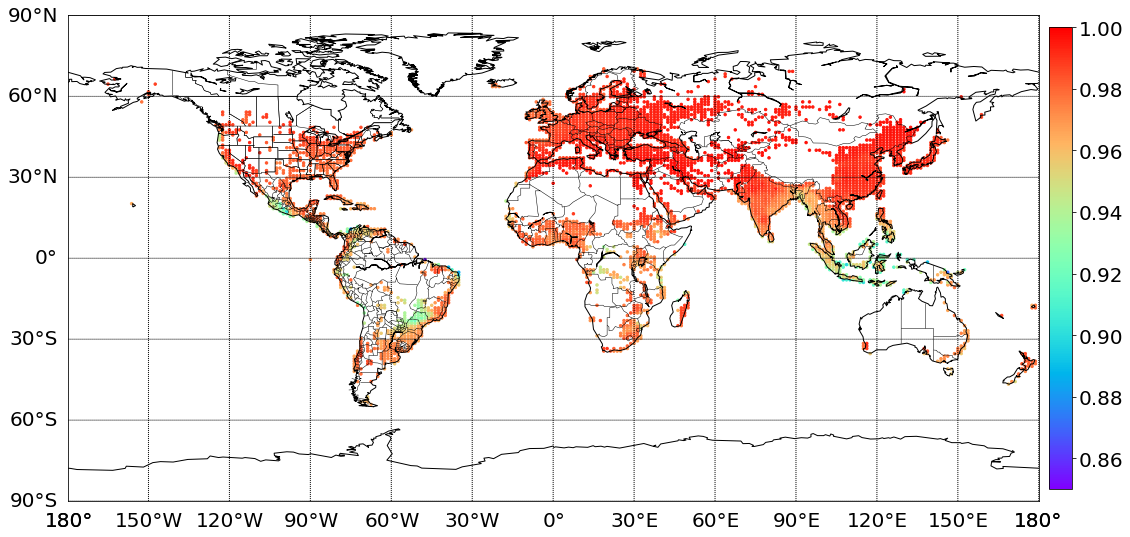

In [7]:
start_year="2006"
df_2006 = pd.read_csv(save_dir+start_year+"/pcc_by_lat_lon_mean.csv")
# df_2006 = pd.read_csv(save_dir+start_year+"/pcc_by_lat_lon_mean.csv",names=["lat", "lon", "0"])
display(df_2006.describe())
global_map_plot(df_2006, "0", 0.85, 1, "rainbow","2006")

### 2061

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.980316
std,25.646228,111.895429,0.016741
min,-54.188499,0.000000,0.835572
25%,8.952900,36.250000,0.973313
50%,29.685900,100.000000,0.985115
75%,42.879601,260.000000,0.992706
max,70.209396,358.750000,0.997669


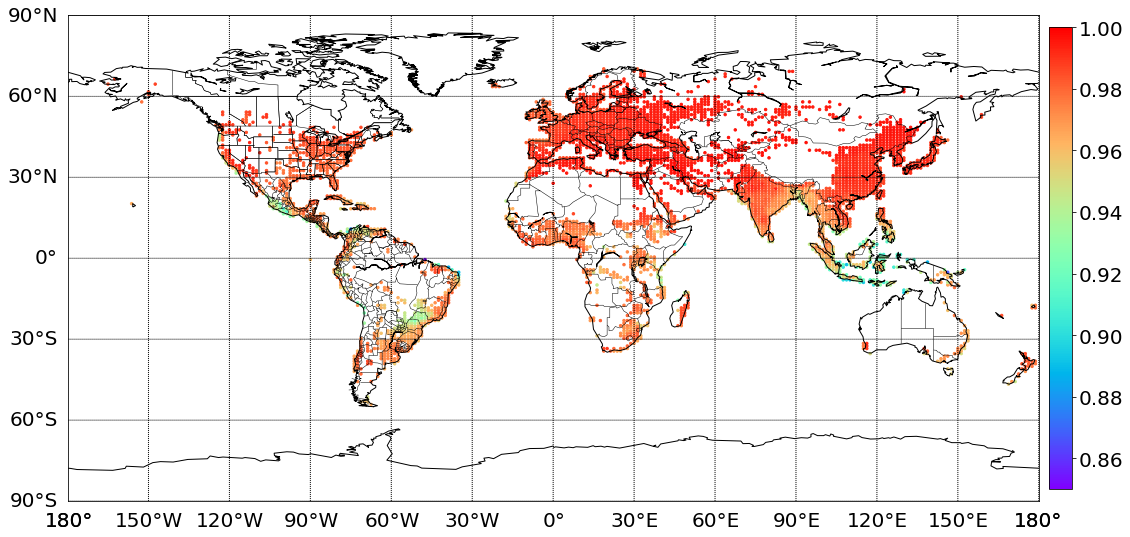

In [8]:
start_year="2061"
df_2006 = pd.read_csv(save_dir+start_year+"/pcc_by_lat_lon_mean.csv")
# df_2006 = pd.read_csv(save_dir+start_year+"/pcc_by_lat_lon_mean.csv",names=["lat", "lon", "0"])
display(df_2006.describe())
global_map_plot(df_2006, "0", 0.85, 1, "rainbow","2061")